# Εύρεση ομοιότητας ομιλητών με χρήση οπτικοακουστικών χαρακτηριστικών  - χρήση μέρους το http://www.robots.ox.ac.uk/~vgg/data/voxceleb/  - υλοποίηση σαν παιχνίδι δεδομένου ενός video ομιλίας λίγων δευτερολέπτων να εμφανίζει τον/την πλησιέστερο διάσημο/η

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
!pwd

/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity


In [3]:
!pip3 install librosa
!pip3 install pyAudioAnalysis
!pip3 install eyed3
!pip3 install pydub

     |████████████████████████████████| 52.4 MB 55 kB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.7-py3-none-any.whl size=52589872 sha256=4bfda9e0696ccf7ae707723f8aa522df0e37869a29856d10f5d4e0fd701d7c1a
  Stored in directory: /root/.cache/pip/wheels/13/5f/c1/647e78637aad4cc6a8fe907d4a1a2f86a148b70c73efd307c4
Successfully built pyAudioAnalysis
     |████████████████████████████████| 245 kB 5.0 MB/s 
     |████████████████████████████████| 242 kB 46.8 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompat

In [4]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate, get_audio_info

2.5.0


## VoxCeleb dataset

VoxCeleb is an audio-visual dataset consisting of short clips of human speech, extracted from interview videos uploaded to YouTube. It is a large scale audio-visual dataset of human speech and contains speakers spanning a wide range of different ethnicities, accents, professions and ages.

We used the VoxCeleb1 dataset which contains over 100,000 utterances for 1,251 celebrities, extracted from videos uploaded to YouTube.

In [5]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [6]:
#check source directory and find classes
source_dir = '/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10894/SelPnm-h2dQ/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10894/tbNEUquzmnQ/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10894/RsdGP9_K35A/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10894/WDG5r-GMZas/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10894/kBTqJuSHqYc/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10894/jpZLYQjm1jY/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio

Create dataframe with speech utterances

In [7]:
df = pd.DataFrame(raw)
df = df[:20000]
print(df.shape)
df.head()

(20000, 2)


,speaker,path
0,id10482,/content/drive/MyDrive/Multimodal_machine_lear...
1,id10482,/content/drive/MyDrive/Multimodal_machine_lear...
2,id10482,/content/drive/MyDrive/Multimodal_machine_lear...
3,id10482,/content/drive/MyDrive/Multimodal_machine_lear...
4,id10482,/content/drive/MyDrive/Multimodal_machine_lear...


## Preprocessing and feature extraction

We split the dataset as 70% for training and 30% for testing. 

The split is performed on every speaker (70% of speaker utterances for train and 30% for testing).

In [8]:
# create train and test dataframes, keep 70% of utterances of each speaker as train set and 30% as test set
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (14001, 2), Test set size (5999, 2)


True

Extract the sample rate and duration of the utterances

In [9]:
# get sample rate and clip duration for every clip
# df_train[['sr','duration']] = df_train['path'].apply(lambda p: get_audio_info(p))
# df_test[['sr','duration']] = df_test['path'].apply(lambda p: get_audio_info(p))

# df_train.head()

In [10]:
# print(f'{df_train.describe()} \n {df_test.describe()}')

## Mel-frequency cepstral coefficients (MFCCs)

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. 

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression. 

MFCCs are commonly used as features in speech recognition systems. MFCCs are also increasingly finding uses in music information retrieval applications such as genre classification and audio similarity measures as in our application.

**MFCC feature extraction procedure**

* **Window the signal** (Frame the signal into short frames)

  For stable acoustic characteristics, speech needs to be examined over a sufficiently short period of time. Therefore, speech analysis must always be carried out on short segments across which the speech signal is assumed to be stationary.

* **Apply Discrete Fourier transform (DFT)**

  Each windowed frame is converted into magnitude spectrum by applying DFT.

* **Take the log of the magnitude**

* **Warp the frequencies on a Mel scale**

  Mel spectrum is computed by passing the Fourier transformed signal through a set of band-pass filters known as Mel-filter bank. A Mel is a unit of measure based on the human ears perceived frequency. It does not correspond linearly to the physical frequency of the tone, as the human auditory system apparently does not perceive pitch linearly. The Mel scale is approximately a linear frequency spacing below 1 kHz and a logarithmic spacing above 1kHz.

  Filter banks can be implemented in both time domain and frequency domain. For MFCC computation, filter banks are generally implemented in frequency domain. The center frequencies of the filters are normally evenly spaced on the frequency axis. However, in order to mimic the human ears perception, the warped axis is implemented. The most commonly used filter shaper is triangular and in some cases the Hanning filter can be found.

* **Apply the inverse Discrete cosine transform (DCT)**

  Since the vocal tract is smooth, the energy levels in adjacent bands tend to be correlated. The DCT is applied to the transformed Mel frequency coefficients produces a set of cepstral coefficients. Prior to computing DCT, the Mel spectrum is usually represented on a log scale. This results in a signal in the cepstral domain with a quefrequency peak corresponding to the pitch of the signal and a number of formants representing low quefrequency peaks. Since most of the signal information is represented by the first few MFCC coefficients, the system can be made robust by extracting only those coefficients ignoring or truncating higher order DCT components.

* **Dynamic MFCC features (delta and delta-delta coefficients)**

  The cepstral coefficients are usually referred to as static features, since they only contain information from a given frame. The extra information about the temporal dynamics of the signal is obtained by computing first and second derivatives of cepstral coefficients. **The first-order derivative is called delta coefficients, and the second-order derivative is called delta–delta coefficients.** Delta coefficients tell about the speech rate, and delta–delta coefficients provide information similar to acceleration of speech. The delta–delta coefficients are computed by taking the first-order derivative of the delta coefficients.

In our application we divided every utterance in 13 window frames and extracted MFCC, delta coefficients and zero-crossing rate features for every window frame

In [11]:
# number of window frames
n_mfcc = splits = 13

# extract MFCC's and delta coefficients
df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

## Zero-crossing rate (ZCR)

Zero crossing rate is the rate at which a signal changes its sign from positive to negative or vice versa within a given time frame.

Zero-crossing rate can be seen as a measure to calculate the noise of a signal. It shows higher values when noise is present. Also it reflects, the spectral characteristics of a signal. It finds use in applications such as speech-music discrimination, speech detection (as in our case) and music genre classification.

In [12]:
# extract Zero-crossing rate (ZCR)
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

train set

In [13]:
df_train.head()

,speaker,path,mfcc,delta,zcr
154,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-359.9907, 95.15752, 10.45771, 5.800337, 15.6...","[0.3250404, -0.23851246, -0.027653718, 0.04388...","[0.05909831613253667, 0.12775665399239544, 0.0..."
215,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-214.8324, 51.1384, 45.96678, 9.847534, 2.308...","[-0.25801998, 0.46541658, -0.0018401744, 0.140...","[0.30820907750286747, 0.2839587088317221, 0.21..."
15,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-198.20454, 69.609726, 55.72582, 8.057278, 0....","[-0.016177244, -0.03783097, 0.10114855, 0.0621...","[0.16806205368135926, 0.3182713617335632, 0.18..."
173,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-422.10852, 112.52294, -0.37938443, 13.780781...","[0.0063912636, -0.07088935, 0.046241783, 0.009...","[0.08803611738148984, 0.10065667966345167, 0.0..."
158,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-295.07648, 90.717384, 26.957735, 27.236208, ...","[0.40661502, -1.1725601, -0.037093118, 0.13806...","[0.0469520615506017, 0.051094890510948905, 0.0..."


test set

In [14]:
df_test.head()

,speaker,path,mfcc,delta,zcr
154,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-359.9907, 95.15752, 10.45771, 5.800337, 15.6...","[0.3250404, -0.23851246, -0.027653718, 0.04388...","[0.05909831613253667, 0.12775665399239544, 0.0..."
215,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-214.8324, 51.1384, 45.96678, 9.847534, 2.308...","[-0.25801998, 0.46541658, -0.0018401744, 0.140...","[0.30820907750286747, 0.2839587088317221, 0.21..."
15,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-198.20454, 69.609726, 55.72582, 8.057278, 0....","[-0.016177244, -0.03783097, 0.10114855, 0.0621...","[0.16806205368135926, 0.3182713617335632, 0.18..."
173,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-422.10852, 112.52294, -0.37938443, 13.780781...","[0.0063912636, -0.07088935, 0.046241783, 0.009...","[0.08803611738148984, 0.10065667966345167, 0.0..."
158,id10482,/content/drive/MyDrive/Multimodal_machine_lear...,"[-295.07648, 90.717384, 26.957735, 27.236208, ...","[0.40661502, -1.1725601, -0.037093118, 0.13806...","[0.0469520615506017, 0.051094890510948905, 0.0..."


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# index mfcc, delta and zero crossing rate
X = df_train.iloc[:,2:5]
# classes
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
# speaker id
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
#split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 174
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (9800, 39), Validation set size (4201, 39)


## Deep Learning Model

We implemented a neural network with the tensorflow framework. We used four hidden layers which included Rectified Linear Units (ReLU) activation functions. For the final layer we used softmax activation function.

Also, 30% dropout was implemented to prevent the network from learning the utterances too well.

Finally, we used categorical_crossentropy to calculate the loss and adam optimizer.

In [16]:
model=Sequential()
# 1st layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# 2nd layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# 3rd layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# 4th layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# 5th layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# 6th layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# 7th layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4000      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               4

We tested for various number of epochs and batch sizes.

In [17]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 600
num_batch_size = 16


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification_20000_samples.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/600
613/613 [==============================] - 6s 7ms/step - loss: 5.3405 - accuracy: 0.0144 - val_loss: 5.0967 - val_accuracy: 0.0428

Epoch 00001: val_loss improved from inf to 5.09674, saving model to saved_models/speakers_classification_20000_samples.hdf5
Epoch 2/600
613/613 [==============================] - 4s 6ms/step - loss: 5.0620 - accuracy: 0.0289 - val_loss: 5.0352 - val_accuracy: 0.0309

Epoch 00002: val_loss improved from 5.09674 to 5.03519, saving model to saved_models/speakers_classification_20000_samples.hdf5
Epoch 3/600
613/613 [==============================] - 4s 6ms/step - loss: 4.9672 - accuracy: 0.0332 - val_loss: 4.9038 - val_accuracy: 0.0309

Epoch 00003: val_loss improved from 5.03519 to 4.90378, saving model to saved_models/speakers_classification_20000_samples.hdf5
Epoch 4/600
613/613 [==============================] - 4s 6ms/step - loss: 4.8737 - accuracy: 0.0417 - val_loss: 4.7827 - val_accuracy: 0.0550

Epoch 00004: val_loss improved from 4.90378 

### Accuracy and loss plots while training

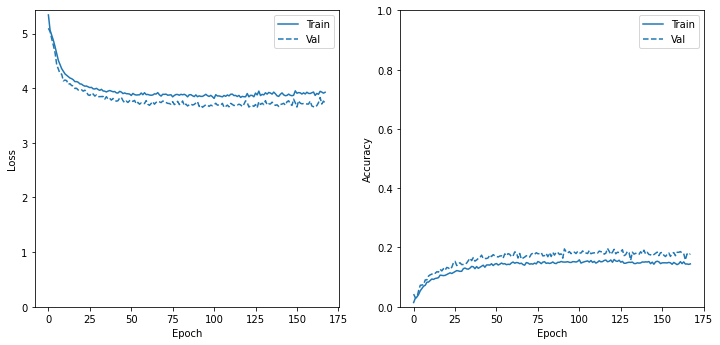

In [18]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Prediction and evaluation

In [19]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(5999, 39)
['id10482' 'id10482' 'id10482' ... 'id10787' 'id10787' 'id10787']
              precision    recall  f1-score   support

     id10037       0.03      0.08      0.04        39
     id10063       0.00      0.00      0.00        34
     id10064       0.00      0.00      0.00        32
     id10065       0.00      0.00      0.00        23
     id10067       0.00      0.00      0.00        33
     id10069       0.00      0.00      0.00        17
     id10082       0.00      0.00      0.00        47
     id10083       0.69      0.13      0.22        70
     id10095       0.00      0.00      0.00        37
     id10096       0.84      0.95      0.89       197
     id10098       0.00      0.00      0.00        24
     id10100       0.00      0.00      0.00        28
     id10116       0.00      0.00      0.00        47
     id10117       0.00      0.00      0.00        17
     id10120       0.50      0.17      0.25        30
     id10123       0.00      0.00      0.00        44
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gausian Mixture Model (GMM)

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. A GMM attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.

A GMM uses an expectation–maximization approach which qualitatively does the following:

* Choose starting guesses for the location and shape

* Repeat until converged:

  E-step: for each point, find weights encoding the probability of membership in each cluster

  M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

In [20]:
from sklearn import mixture
# for every speaker fit a GMM and save the model
unique_speakers = df_train['speaker'].unique()
for speaker in unique_speakers:
    df_speaker = df_train[df_train['speaker'] == speaker]
    features = np.asarray(())
    for index, row in df_speaker.iterrows():
        vector = np.hstack((row['mfcc'], row['delta'], row['zcr']))
        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features,vector))

    # fit a Gaussian Mixture Model with 16 components
    gmm = mixture.GaussianMixture(n_components = 16, covariance_type='diag',n_init = 3)
    gmm.fit(features)
    # save model
    filename = 'saved_models/gmm/' + f'gmm_{speaker}.sav'
    pickle.dump(gmm, open(filename, 'wb'))

In [21]:
# load models and predict on test set
gmm_files = [os.path.join('saved_models/gmm/',fname) for fname in 
              os.listdir('saved_models/gmm/') if fname.endswith('.sav')]

# load the GMM models
gmm_models = [pickle.load(open(fname,'rb')) for fname in gmm_files]
unique_speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname 
              in gmm_files]

print(unique_speakers)
nr_errors = 0
total_samples = len(df_test)
for index, row in df_test.iterrows():
    log_likelihood = np.zeros(len(gmm_models)) 
    features = np.hstack((row['mfcc'], row['delta'], row['zcr']))
    features = features.reshape(1,-1)
    
    for i, gmm in enumerate(gmm_models):
        scores = np.array(gmm.score(features))
        log_likelihood[i] = scores.sum()

    y_pred = np.argmax(log_likelihood)
    if unique_speakers[y_pred] != 'gmm_' + row['speaker']+ '.sav':
        nr_errors += 1

accuracy = ((total_samples - nr_errors) / total_samples) * 100
print (f'The Accuracy with (MFCC + DELTA + ZCR) and GMM is : {accuracy}')

['gmm_id10001.sav', 'gmm_id10002.sav', 'gmm_id10482.sav', 'gmm_id10659.sav', 'gmm_id10564.sav', 'gmm_id10083.sav', 'gmm_id10618.sav', 'gmm_id10261.sav', 'gmm_id10548.sav', 'gmm_id10390.sav', 'gmm_id10069.sav', 'gmm_id10769.sav', 'gmm_id10187.sav', 'gmm_id10718.sav', 'gmm_id10082.sav', 'gmm_id10529.sav', 'gmm_id10184.sav', 'gmm_id10478.sav', 'gmm_id10617.sav', 'gmm_id10734.sav', 'gmm_id10547.sav', 'gmm_id10100.sav', 'gmm_id10706.sav', 'gmm_id10686.sav', 'gmm_id10437.sav', 'gmm_id10757.sav', 'gmm_id10181.sav', 'gmm_id10768.sav', 'gmm_id10355.sav', 'gmm_id10237.sav', 'gmm_id10717.sav', 'gmm_id10657.sav', 'gmm_id10562.sav', 'gmm_id10436.sav', 'gmm_id10417.sav', 'gmm_id10067.sav', 'gmm_id10491.sav', 'gmm_id10236.sav', 'gmm_id10705.sav', 'gmm_id10781.sav', 'gmm_id10475.sav', 'gmm_id10733.sav', 'gmm_id10098.sav', 'gmm_id10544.sav', 'gmm_id10435.sav', 'gmm_id10590.sav', 'gmm_id10124.sav', 'gmm_id10716.sav', 'gmm_id10183.sav', 'gmm_id10235.sav', 'gmm_id10467.sav', 'gmm_id10354.sav', 'gmm_id1076